In [233]:
%load_ext autoreload
%autoreload 2
from storytelling import *
from bert_extractive_summarizer.summarizer import Summarizer
from bert_extractive_summarizer.summarizer.coreference_handler import CoreferenceHandler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [234]:
word_embeddings = LoadWordEmbeddings(fil="../dat/glove/glove.twitter.27B.100d.txt")

In [352]:
datfile = "../dat/wildfire_yosemite.csv"
#datfile = "../dat/1966.csv.gz"
df = pd.read_csv(datfile, index_col="id")
df = df[df["rt_id"].isna()]
print(df.shape)

(3582, 11)


In [353]:
df1 = df[df["user_followers_count"]>10**3]
df1.shape

(1848, 11)

In [354]:
tids, row_sentences, clean_sentences = readsencence(df1)

In [355]:
print(len(tids), tids[:3])

1341 [370587609350684672, 370595563042906112, 370587253325578240]


In [356]:
sentence_vectors = Sentence2WE(clean_sentences, word_embeddings)

In [357]:
sentence_vectors
print(sentence_vectors.shape)

(1341, 100)


(1341, 40)


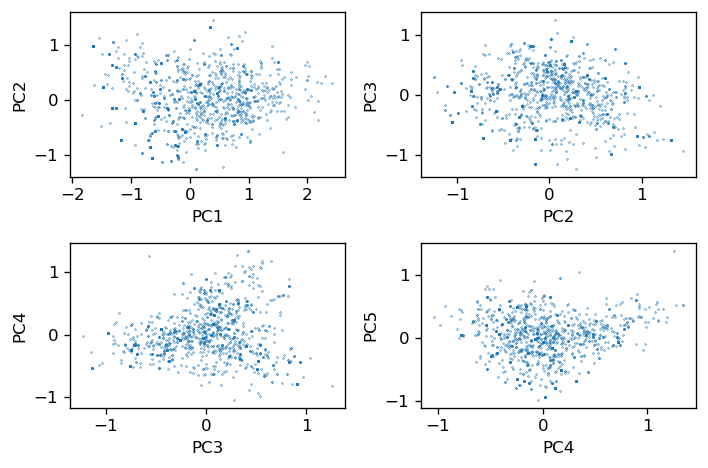

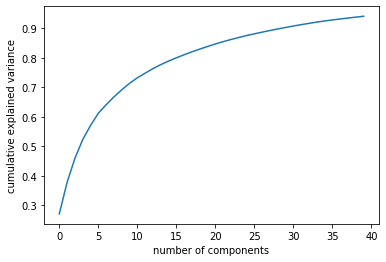

In [358]:
pca = PCA(n_components=40, svd_solver='arpack')
X = pca.fit_transform(sentence_vectors)
print(X.shape)
fig, axs = plt.subplots(2,2,dpi=120)
for i,(j,k) in enumerate([(0,0),(0,1),(1,0),(1,1)]):
    axs[j,k].scatter(X[:,i], X[:,i+1], s=0.1)
    axs[j,k].set_xlabel("PC%d"%(i+1))
    axs[j,k].set_ylabel("PC%d"%(i+2))
fig.tight_layout()
plt.show()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [359]:
for nc, vexp in enumerate(np.cumsum(pca.explained_variance_ratio_)):
    if vexp > 0.9:
        NC = nc+1
        break
print(NC)

30


In [360]:
tsne = TSNE(n_components=2)
Y = tsne.fit_transform(X[:, :NC])

In [361]:
#Agg = sklearn.cluster.AgglomerativeClustering(n_clusters=10, affinity="cosine",linkage="average")
Agg = sklearn.cluster.AgglomerativeClustering(distance_threshold=1.5, n_clusters=None, affinity="cosine",linkage="complete")
Agg = Agg.fit(X[:, :NC])
clusters = Agg.fit_predict(X[:, :NC])
groups = AssignCluster(Y, clusters)
print(len(groups))
#centers = kmeans.cluster_centers_ 

8


In [362]:
Agg.labels_

array([1, 2, 2, ..., 7, 7, 6])

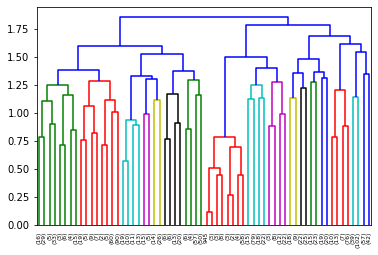

In [363]:
plot_dendrogram(Agg, truncate_mode='level', p=5)

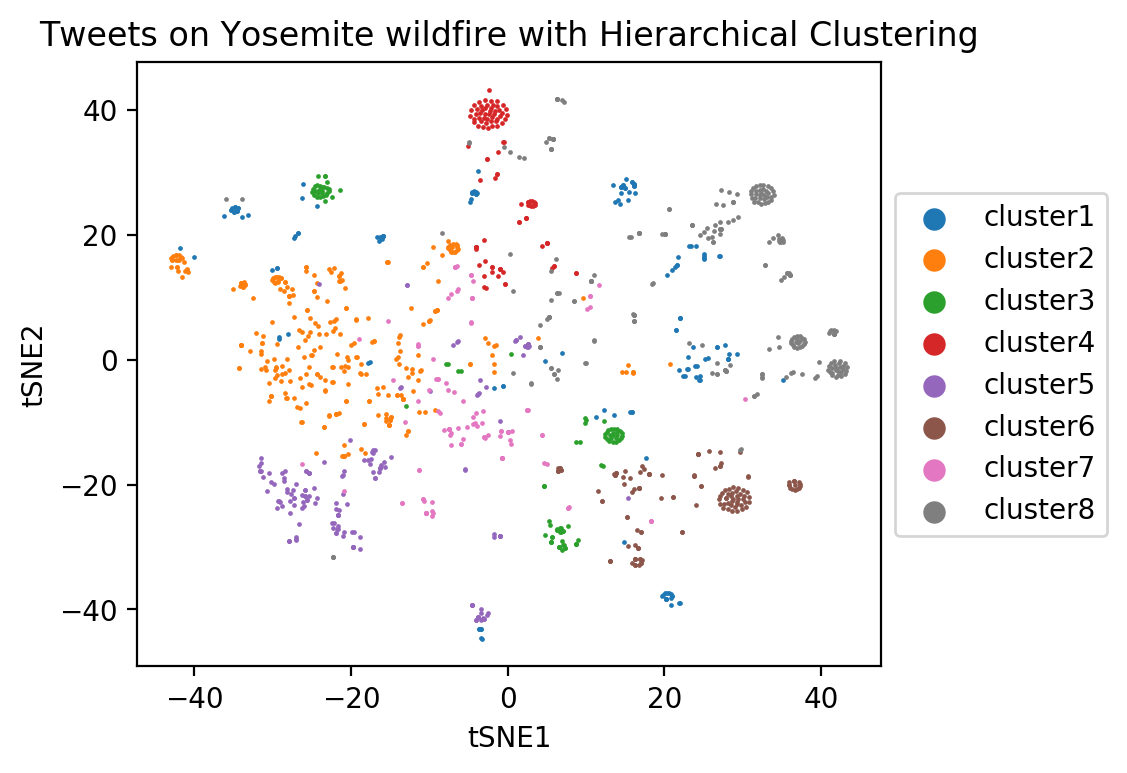

In [364]:
fig = plt.figure(dpi=200)
ax = plt.subplot(111)
for i, group in enumerate(groups):
    group = np.array(group)
    ax.scatter(group[:, 0], group[:, 1], label="cluster%d"%(i+1), s=0.5)
#ax.scatter(centers[:,0], centers[:,1], s=4, color="black", marker="x")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgnd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, markerscale=10.)
ax.set_xlabel("tSNE1")
ax.set_ylabel("tSNE2")
plt.title("Tweets on Yosemite wildfire with Hierarchical Clustering")
plt.show()

In [365]:
Totoal_art = []
for i in range(max(clusters)+1):
    topics = np.where(clusters==i)[0]
    if len(topics) < 5:
        continue
    topic_tweet_idxs = np.array([tids[int(i)] for i in topics])
    topic_sentence_vectors = np.array([sentence_vectors[int(i)] for i in topics])
    sim_mat = TextRankScoreMat(topic_sentence_vectors)
    threashold = 0.8
    rm_idx = []
    kept_idx = []
    for i in range(sim_mat.shape[0]):
        if i in rm_idx:
            continue
        kept_idx.append(i)
        for j in range(sim_mat.shape[1]):
            if sim_mat[i,j]>threashold:
                rm_idx.append(j)   
    #print(len(kept_idx))
    art = []
    selected_Clean = []
    for i in kept_idx:
        dat_id = topics[i]
        tid = tids[dat_id]
        date = datetime.strptime(df1.loc[tid, "created_at"],'%a %b %d %X %z %Y').strftime("%m-%d-%X")
        if len(row_sentences[dat_id]) > 20:
            art.append(row_sentences[dat_id])
            selected_Clean.append(clean_sentences[dat_id])
    #print(art)
    Totoal_art.append(".".join(art))
#print(Totoal_art)
print("\n".join(Totoal_art))

Wildfire near Yosemite burns out of control threatens more than 2000 structures -.State Of Emergency Declared For Yosemite-Area  Wildfire Thousands Evacuated.Wildfire Near Yosemite Surges Prompts Evacuations.tcot  teaparty  tgdn  sgp  gop.Tourists flee as wildfire at Yosemite triples in size.France Vows Syrian Action — Coptic Christian Violence — Yosemite Wildfire — Secret Spy Base….1 800 firefighters battle Yosemite wildfire.Yosemite-area wildfire growing at alarming rate.Tourists flee wildfire near Yosemite  bbc  bbcnews  bbcworld.Wildfire spreads to Yosemite  teamfollowback.Photos From the Massive Yosemite Wildfire    4jobs  2futures  ClimateChange  p2  tcot  pjnet
Yosemite area wildfire balloons in size overnight.Yosemite-area wildfire balloons to 84 square miles.theblaze   tcot Yosemite-area wildfire balloons to 84 square miles (twincities).RateTake: Yosemite wildfire surges to 84 square miles.Wildfire near Yosemite surges prompts evacuations (from  ).world  news VIDEO: Tourists f

In [366]:
out = open("test.psodu.txt", 'wt')
out.write("\n".join(Totoal_art))

3690

In [367]:
model = "bert-large-uncased"
hidden = -2
reduce_option = "mean"
model = Summarizer(
    model = model,
    hidden = hidden,
    reduce_option = reduce_option)

In [368]:
result = model("\n".join(Totoal_art))#, min_length=80)
print(result)

Wildfire near Yosemite burns out of control threatens more than 2000 structures -.State Of Emergency Declared For Yosemite-Area  Wildfire Thousands Evacuated. Tourists flee wildfire near Yosemite  bbc  bbcnews  bbcworld. Wildfire spreads to Yosemite National Park. " Bay Area Campers Among Thousands Evacuated From Yosemite-Area  Wildfire. RimFire   issues emergency proclamation Thurs. Big Yosemite wildfire remains largely out-of-control.


In [369]:
result = model("\n".join(Totoal_art), min_length=1)
print(result)

Wildfire near Yosemite burns out of control threatens more than 2000 structures -.State Of Emergency Declared For Yosemite-Area  Wildfire Thousands Evacuated. Tourists flee wildfire near Yosemite  bbc  bbcnews  bbcworld. Calif. wildfire quadruples in size. Wildfire spreads to Yosemite National Park. " wildfire. RimFire   issues emergency proclamation Thurs. Big Yosemite wildfire remains largely out-of-control. Beastly Fire Disrupts Idaho Vacation Heaven.


In [370]:
import language_check

In [371]:
tool = language_check.LanguageTool('en-US')

In [372]:
for sent in nltk.tokenize.sent_tokenize(result):
    print(sent)
    matches = tool.check(sent)
    for match in matches:
        print(match.context, match.errorlength, match.category)
    
    print()

Wildfire near Yosemite burns out of control threatens more than 2000 structures -.State Of Emergency Declared For Yosemite-Area  Wildfire Thousands Evacuated.
...l threatens more than 2000 structures -.State Of Emergency Declared For Yosemite-Area... 5 Miscellaneous
... Of Emergency Declared For Yosemite-Area  Wildfire Thousands Evacuated. 2 Miscellaneous

Tourists flee wildfire near Yosemite  bbc  bbcnews  bbcworld.
Tourists flee wildfire near Yosemite  bbc  bbcnews  bbcworld. 2 Miscellaneous
Tourists flee wildfire near Yosemite  bbc  bbcnews  bbcworld. 3 Possible Typo
...ourists flee wildfire near Yosemite  bbc  bbcnews  bbcworld. 2 Miscellaneous
...rists flee wildfire near Yosemite  bbc  bbcnews  bbcworld. 7 Possible Typo
...lee wildfire near Yosemite  bbc  bbcnews  bbcworld. 2 Miscellaneous
...e wildfire near Yosemite  bbc  bbcnews  bbcworld. 8 Possible Typo

Calif. wildfire quadruples in size.
Calif. wildfire quadruples in size. 8 Capitalization

Wildfire spreads to Yosemite Natio

In [373]:
text = "This is perfect"
text = "Yosemite wildfire impacting SF water power"
text = "Update: rt      Wildfire near  Yosemite surges prompts evacuations:"
matches = tool.check(text)

In [374]:
for match in matches:
    print(match.context, match.errorlength, match.category)
#print(matches.errorlength, matches.length)

Update: rt      Wildfire near  Yosemite surges prompts e... 6 Miscellaneous
Update: rt      Wildfire near  Yosemite surges prompts evacuations: 2 Miscellaneous


In [375]:
matches

[Match({'fromy': 0, 'fromx': 10, 'toy': 0, 'tox': 16, 'ruleId': 'WHITESPACE_RULE', 'msg': 'Possible typo: you repeated a whitespace', 'replacements': [' '], 'context': 'Update: rt      Wildfire near  Yosemite surges prompts e...', 'contextoffset': 10, 'offset': 10, 'errorlength': 6, 'category': 'Miscellaneous', 'locqualityissuetype': 'whitespace'}),
 Match({'fromy': 0, 'fromx': 29, 'toy': 0, 'tox': 31, 'ruleId': 'WHITESPACE_RULE', 'msg': 'Possible typo: you repeated a whitespace', 'replacements': [' '], 'context': 'Update: rt      Wildfire near  Yosemite surges prompts evacuations:', 'contextoffset': 29, 'offset': 29, 'errorlength': 2, 'category': 'Miscellaneous', 'locqualityissuetype': 'whitespace'})]

In [376]:
language_check.correct(text, matches)

'Update: rt Wildfire near Yosemite surges prompts evacuations:'

In [377]:
All = "\n".join(Totoal_art)
New_ALL = []
for sent in All.split("."):
    #print(sent)
    sent = sent.strip().strip(":").strip(" ").strip(":").strip(" ")
    if len(sent.strip().split()) < 4 or " — " in sent or "$$" in sent:
        continue
    matches = tool.check(sent)
    if len(matches)<=3:
        #print(language_check.correct(sent, matches))
    #for match in matches:
    #    print(match.context, match.errorlength, match.category)
        New_ALL.append(sent)
New_ALL = ". ".join(New_ALL)

In [381]:
New_ALL

'Wildfire near Yosemite burns out of control threatens more than 2000 structures -. State Of Emergency Declared For Yosemite-Area  Wildfire Thousands Evacuated. Wildfire Near Yosemite Surges Prompts Evacuations. Tourists flee as wildfire at Yosemite triples in size. 1 800 firefighters battle Yosemite wildfire. Yosemite-area wildfire growing at alarming rate. Wildfire spreads to Yosemite  teamfollowback. Yosemite-area wildfire balloons to 84 square miles. RateTake: Yosemite wildfire surges to 84 square miles. Wildfire near Yosemite surges prompts evacuations (from  ). world  news VIDEO: Tourists flee wildfire near Yosemite. wildfire quadruples in size. Dry weather fuels Yosemite wildfire. A massive California wildfire raged at the backcountry edge of Yosemite…. Vast wildfire reaches Yosemite park. " : Wildfire spreads to Yosemite National Park. nowreading  topics Huge Calif. Wildfire Spreads Into Yosemite\nYosemite-area Wildfire Balloons In Size Overnight:  montereybay. A wildfire is bu

In [378]:
result = model(New_ALL)#, min_length=80)
print(result)

Wildfire near Yosemite burns out of control threatens more than 2000 structures -. Tourists flee as wildfire at Yosemite triples in size. Yosemite-area wildfire growing at alarming rate. From CI Top Broker: "Wildfire near Yosemite National Park more than triples in size overnight". RimFireCA Fire Fighters Lose Ground Against Growing Wildfire Camp Closeing info  hmrd. Monster" Yosemite-area fire growing at alarming rate. ( Many fleeing Yosemite-area wildfire which has grown to 99 square miles  ”. Big Yosemite wildfire remains largely out-of-control.


In [379]:
New_ALL

'Wildfire near Yosemite burns out of control threatens more than 2000 structures -. State Of Emergency Declared For Yosemite-Area  Wildfire Thousands Evacuated. Wildfire Near Yosemite Surges Prompts Evacuations. Tourists flee as wildfire at Yosemite triples in size. 1 800 firefighters battle Yosemite wildfire. Yosemite-area wildfire growing at alarming rate. Wildfire spreads to Yosemite  teamfollowback. Yosemite-area wildfire balloons to 84 square miles. RateTake: Yosemite wildfire surges to 84 square miles. Wildfire near Yosemite surges prompts evacuations (from  ). world  news VIDEO: Tourists flee wildfire near Yosemite. wildfire quadruples in size. Dry weather fuels Yosemite wildfire. A massive California wildfire raged at the backcountry edge of Yosemite…. Vast wildfire reaches Yosemite park. " : Wildfire spreads to Yosemite National Park. nowreading  topics Huge Calif. Wildfire Spreads Into Yosemite\nYosemite-area Wildfire Balloons In Size Overnight:  montereybay. A wildfire is bu